## 0. Import packages

In [1]:
# model imports

import numpy as np

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
from rouwenhorst import rouwenhorst
import jacobian as jac
import nonlinear
import HANK_durables as hank
import determinacy as det
from scipy import optimize

# DAG imports
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import pandas as pd

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

Let's attach this hetinput function to the generic household HetBlock using (the aptly-named) ``HetBlock.attach_hetinput`` method.

In [2]:
household = hank.household

<a id="2-calibration"></a>

## 1. Calibrating the steady state


In [3]:
def hank_ss(beta_guess=0.9745, r=0.03/4, sigma_N=1.0, sigma_D=1.0, delta=0.1, alpha = 4.0, vareps=10.0, tau_e = 0,  rho_e=0.9777, sigma_e=0.1928,
            phi_pi=1.5, phi_y = 0.125, theta = 8.0, xi = 105, Ne=7, Nb=80, Nd=90,  bmax=150, dmax=135):
    """Solve steady state of full GE model. Calibrate beta to hit target interest rate where parameters adjust to get N=1, Y=1, Q=1"""

    # a. set up grids
    psi = 0.5 # "bmin":: psi*Y, Y=1
    b_grid = utils.agrid(amax=bmax, n=Nb, amin=-psi)
    d_grid = utils.agrid(amax=dmax, n=Nd, amin=1e-6)
    e_grid_log, e_ergodic, Pi_e = rouwenhorst(rho_e,sigma_e,Ne)
    e_grid = np.exp(e_grid_log) / np.sum(e_ergodic * np.exp(e_grid_log)) # normalize so E[e]=1
    Nk = Nd # number of grid points for lagrange multiplier grid
    kmax = 1.0 # 1 = max for lagrange mult.
    k_grid = utils.agrid(amax=kmax,n=Nk,amin=0)
    
    # b. solve analytically what we can (zero inflation s.s.)
    N = 1.0 # as psi_N = W/P_n * 1/C, psi_N found after root finding
    Q = 1.0 # as chi = C / (C+D), chi found after root finding
    A = 1.0/N # s.s. TFP level, set such that Y = 1
    markup_p_ss = vareps/(vareps-1) # P mark-up
    P = 1.0 # numeriare
    W = (A*P)/markup_p_ss
    Y = A*N # Y = 1
    P_n = P # price of non-durables, follows from retailer price relation
    P_d = P # price of durables, follows from retailer price relation
    Div = Y - N*(W/P) # s.s. profits

    # c. initialize guess for policy function iteration
    c = (b_grid[:, np.newaxis] + d_grid)/2
    c[c<0] = 1e-8 # assert c>0
    d = c 
    Vb = c**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
    Vd = d**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
        
    # d. pre-compute RHS of combined F.O.C. optimality condition
    P_d_p = P_d/P
    rhs = P_d_p + alpha*((d_grid[:, np.newaxis]/d_grid[np.newaxis, :]) - (1-delta)) # P_d/P + partial Psi/partial d'

    # e. define residual function
    def residual(x0):

        # a. solve household ss problem
        out = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,Div=Div,beta=x0,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e)
        
        #print(x0,[out['B'] - 0],out['DG'],out['C'])
                                 
        return np.array([out['B'] - 0]) # bonds are in zero net-supply

    # f. solve for beta given asset market clearing
    # i. call optimizer
    result = optimize.root_scalar(residual,bracket=[1/(1+r)-0.05,1/(1+r)],method='bisect') # cannot go higher than 1/(1+r)
    # ii. save result
    beta = result.root
    

    # g. extra evaluation for reporting
    ss = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,Div=Div,beta=beta,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e)
    
    # h. update parameters that take adjustment for hitting targets in wage schedule and combined retailer FOC equations
    psi_N = (W/P) * (1/ss['C'])
    chi = ss['C']/(ss['C']+ss['C_D'])
        
    # h. add aggregate variables
    ss.update({'phi_pi': phi_pi, 'phi_y': phi_y, 'Y': Y, 'Y_ss': Y, 'rstar': r, 'markup_p_ss': markup_p_ss, 'markup_p': markup_p_ss, 'A': A, 'N': N, 'P': P, 'Pi': P/P, 'W': W,
               'chi': chi, 'psi_N': psi_N, 'dg_grid': d_grid, 'Q': Q, 'P_d': P_d, 'P_n': P_n, 'Div': Div, 'vareps': vareps, 'phi_pi': phi_pi, 'phi_y': phi_y,
               'theta': theta, 'xi': xi, 'sigma_N': sigma_N, 'sigma_D': sigma_D, 'e_ergodic': e_ergodic,'ssflag': False}) # P_d=P_n=P+eps for numerical stability
    return ss

In [4]:
ss = hank_ss()
ss['beta']

0.9685812636239461

# 2. Steady-state distributions plots and tables

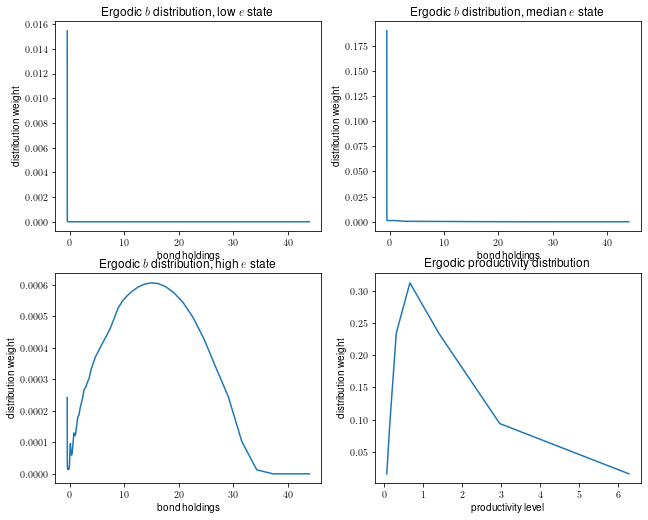

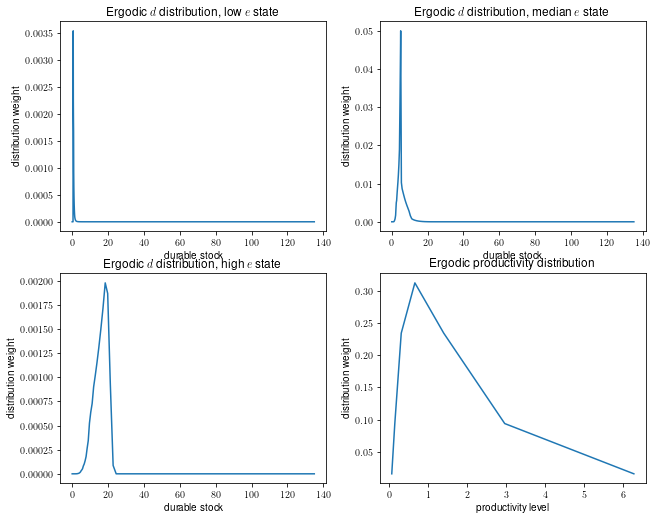

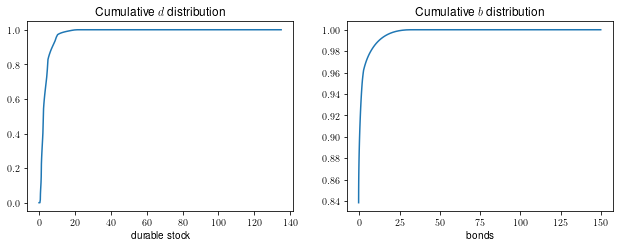

In [5]:
# a. marginal distributions
bdmargdist = np.sum(ss['D'],axis=0) # sum out e
dmargdist = np.sum(ss['D'],axis=1) # sum out b
dmargcum = np.cumsum(dmargdist)
bmargdist = np.sum(ss['D'],axis=2) # sum out d
bmargcum = np.cumsum(bmargdist)
e_ergodic = ss['e_ergodic']

# b. cumulative distributions
d_margdist = np.sum(bdmargdist,axis=0) # sum out b
dmargcum = np.cumsum(d_margdist)
b_margdist = np.sum(bdmargdist,axis=1) # sum out d
bmargcum = np.cumsum(b_margdist)


# b. plots 
fig1 = plt.figure()
fig1.set_size_inches(10.5, 8.5)
ax1 = fig1.add_subplot(221)
ax1.plot(ss['b_grid'][:65],bmargdist[0,:65])
ax2 = fig1.add_subplot(222)
ax2.plot(ss['b_grid'][:65],bmargdist[4,:65])
ax3 = fig1.add_subplot(223)
ax3.plot(ss['b_grid'][:65],bmargdist[-1,:65])
ax4 = fig1.add_subplot(224)
ax4.plot(ss['e_grid'],ss['e_ergodic'])
ax1.title.set_text('Ergodic $b$ distribution, low $e$ state')
ax1.set_xlabel('bond holdings')
ax1.set_ylabel('distribution weight')
ax2.title.set_text('Ergodic $b$ distribution, median $e$ state')
ax2.set_xlabel('bond holdings')
ax2.set_ylabel('distribution weight')
ax3.title.set_text('Ergodic $b$ distribution, high $e$ state')
ax3.set_xlabel('bond holdings')
ax3.set_ylabel('distribution weight')
ax4.title.set_text('Ergodic productivity distribution')
ax4.set_xlabel('productivity level')
ax4.set_ylabel('distribution weight')
plt.show()
fig1.tight_layout(pad=7.0)
fig1.savefig("b_dists.pdf", bbox_inches='tight')

fig2 = plt.figure()
fig2.set_size_inches(10.5, 8.5)
ax1 = fig2.add_subplot(221)
ax1.plot(ss['dg_grid'][:100],dmargdist[0,:100])
ax2 = fig2.add_subplot(222)
ax2.plot(ss['dg_grid'][:100],dmargdist[4,:100])
ax3 = fig2.add_subplot(223)
ax3.plot(ss['dg_grid'][:100],dmargdist[-1,:100])
ax4 = fig2.add_subplot(224)
ax4.plot(ss['e_grid'],ss['e_ergodic'])
ax1.title.set_text('Ergodic $d$ distribution, low $e$ state')
ax1.set_xlabel('durable stock')
ax1.set_ylabel('distribution weight')
ax2.title.set_text('Ergodic $d$ distribution, median $e$ state')
ax2.set_xlabel('durable stock')
ax2.set_ylabel('distribution weight')
ax3.set_xlabel('durable stock')
ax3.set_ylabel('distribution weight')
ax3.title.set_text('Ergodic $d$ distribution, high $e$ state')
ax4.set_xlabel('durable stock')
ax4.set_ylabel('distribution weight')
ax4.title.set_text('Ergodic productivity distribution')
ax4.set_xlabel('productivity level')
ax4.set_ylabel('distribution weight')

plt.show()
fig2.tight_layout(pad=7.0)
fig2.savefig("d_dists.pdf", bbox_inches='tight')

fig3 = plt.figure()
fig3.set_size_inches(10.5, 3.5)
ax1 = fig3.add_subplot(121)
ax1.plot(ss['dg_grid'],dmargcum)
ax2 = fig3.add_subplot(122)
ax2.plot(ss['b_grid'],bmargcum)
ax1.title.set_text('Cumulative $d$ distribution')
ax1.set_xlabel('durable stock')
ax2.title.set_text('Cumulative $b$ distribution')
ax2.set_xlabel('bonds')

plt.show()
fig3.tight_layout(pad=4.0)
fig3.savefig("CDFs.pdf", bbox_inches='tight')

In [6]:
# a. percentiles
moms = {}
pvec = [0.001,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.999]
for p in pvec:

    # durable
    if p <= dmargcum[0]:
        moms[('d',p)] = ss['dg_grid'][0]
    else:
        try:
            moms[('d',p)] = np.interp(p,dmargcum,ss['dg_grid'])
        except:
            moms[('d',p)] = np.nan

    # bonds
    if p <= bmargcum[0]:
        moms[('b',p)] = ss['b_grid'][0]
    else:
        try:
            moms[('b',p)] = np.interp(p,bmargcum,ss['b_grid'])
        except:
            moms[('b',p)] = np.nan
            
# b. table
print('d percentiles')
for p in reversed(pvec):
    print("%.2f" % p,"%.2f" % moms['d',p])
print('')
print('b percentiles')
for p in reversed(pvec):
    print("%.2f" % p,"%.2f" % moms['b',p])

d percentiles
1.00 19.97
0.99 15.20
0.95 9.41
0.90 7.37
0.75 4.47
0.50 2.41
0.25 1.41
0.10 1.02
0.05 0.78
0.01 0.61
0.00 0.49

b percentiles
1.00 24.40
0.99 12.20
0.95 1.69
0.90 0.10
0.75 -0.50
0.50 -0.50
0.25 -0.50
0.10 -0.50
0.05 -0.50
0.01 -0.50
0.00 -0.50


# 3. Linearized dynamics

## 3.1 Equilibrium equations neccessary to compute impulse responses

$$P_{t}=\left[\chi P_{n,t}^{1-\theta}+(1-\chi)P_{d,t}^{1-\theta}\right]^{\frac{1}{1-\theta}}$$

$$\Pi_{t}=\frac{P_{t}}{P_{t-1}}$$

$$Q_{t}=\frac{P_{d,t}}{P_{n,t}}$$

$$\mathcal{M}_{t}^{p}=\frac{1}{\frac{\xi}{\epsilon}\left(\Pi_{t}\left(\Pi_{t}-1\right)-\frac{1}{1+r_{t+1}}\left(\frac{Y_{t+1}}{Y_{t}}\right)\Pi_{t+1}\left(\Pi_{t+1}-1\right)\right)+\frac{1}{\mathcal{M}^{p}}}$$

$$i_{t}=r_{t}^{*}+\phi_{\pi}\pi_{t}+\phi_{y}\left(Y_{t}-Y_{ss}\right)$$

$$r_{t}=\frac{1+i_{t}}{1+\pi_{t}}-1$$

$$N_{t}=Y_{t}/A_{t}$$

$$W_{t}=\frac{A_{t} P_{t}}{\mathcal{M}_{t}^{p} }$$

$$Div_{t}=Y_{t}\left(1-(\xi/2)\left(\Pi_{t}-1\right)^{2}\right)-\frac{W_{t}}{P_{t}}N_{t}$$

$$B_{t}/P_{t}=0$$

$$\left(\frac{\chi}{1-\chi}\frac{D_t}{C_t}\right)^{\frac{1}{\theta}}=\frac{1}{Q_{t}}$$

$$\frac{W_{t}}{P_{t}}=\psi_N N_{t}C_{n,t}$$

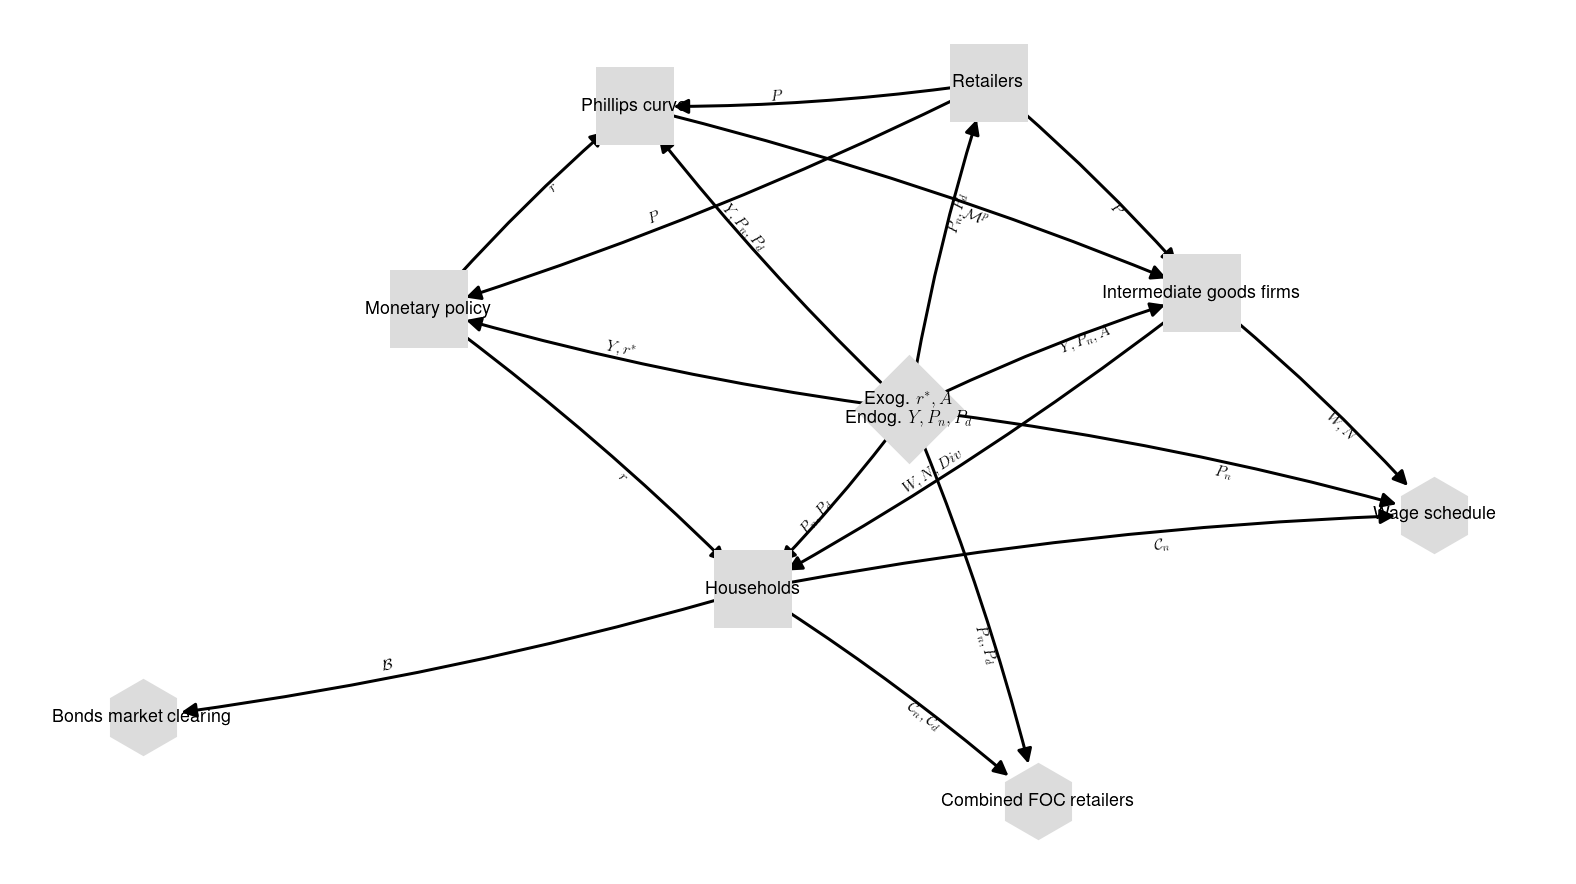

In [7]:
#### a. Create directed graph: Define nodes + edges
G = nx.DiGraph()

# 1. define node s
G.add_node(1,label=r"""Exog. $r^*,A$
Endog. $Y,P_{n},P_{d}$""",s  = 'D')

G.add_node(2,label=r"""Intermediate goods firms""",s  = 's')
G.add_node(9,label=r"""Retailers""",s  = 's')
G.add_node(3,label=r"""Monetary policy""",s  = 's')
G.add_node(4,label=r"""Households""",s  = 's')
G.add_node(5,label=r"""Phillips curve""",s  = 's')

G.add_node(6,label=r"""Bonds market clearing""",s  = 'h')
G.add_node(7,label=r"""Combined FOC retailers""",s  = 'h')
G.add_node(8,label=r"""Wage schedule""",s  = 'h')



# 2. define edges
G.add_edge(1,2)
G.add_edge(1,5)
G.add_edge(1,3)
G.add_edge(5,2)
G.add_edge(3,5)
G.add_edge(1,4)
G.add_edge(2,4)
G.add_edge(3,4)

G.add_edge(4,6)
G.add_edge(4,7)
G.add_edge(4,8)
G.add_edge(1,7)
G.add_edge(1,8)
G.add_edge(2,8)

G.add_edge(1,9)
G.add_edge(9,5)
G.add_edge(9,2)
G.add_edge(9,3)


# b. drawing the graph
# 1. obtain node positions using optimal kamada kawai layout
df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
for row, data in nx.shortest_path_length(G):
    for col, dist in data.items():
        df.loc[row,col] = dist

df = df.fillna(df.max().max())

nodePos = nx.kamada_kawai_layout(G, dist=df.to_dict())

#nodePos = nx.layout.spring_layout(G,k=1,iterations=2)

# 2. get all distinct node classes according to the node shape attribute
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))
labels = {node:G.nodes[node]['label'] for node in G.nodes()}

plt.figure(1,figsize=(28,16)) 

# 3. filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
node_size = 6000
for aShape in nodeShapes:
    nx.draw_networkx_nodes(G,nodePos,node_size = node_size, linewidths=0, node_color = '#DCDCDC',node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))])

# 4. finally, draw the edges between the nodes
nx.draw_networkx_edges(G,nodePos, width=3, arrowsize=30, connectionstyle = "arc3,rad=-0.04",node_size = node_size)

# 5. label nodes and edges
nx.draw_networkx_labels(G,nodePos,labels,font_size=18,font_color='black')
nx.draw_networkx_edge_labels(G,nodePos,label_pos=0.4,edge_labels={(1,2):r"$Y, P_n, A$",(1,5):r"$Y, P_n, P_d$",(5,2):r"$\mathcal{M}^p$",(1,3):r"$Y, r^*$",
                                                                 (2,4):r"$W,N,Div$",(3,4):r"$r$",(3,5):r"$r$",(4,6):r"$\mathcal{B}$",(4,7):r"$\mathcal{C}_n,\mathcal{C}_d$",
                                                                 (4,8):r"$\mathcal{C}_n$",(1,7):r"$P_n,P_d$",(1,8):r"$P_n$",(2,8):r"$W,N$",(1,4):r"$P_n,P_d$",
                                                                  (1,9):r"$P_n,P_d$",(9,5):r"$P$",(9,2):r"$P$",(9,3):r"$P$"},font_color='black', font_size=16, bbox = dict(facecolor='white', alpha=0))


# 6. show the final result and save plot
plt.axis('off')
#plt.savefig('DAG_durables.pdf', bbox_inches="tight", pad_inches = 0)
plt.show()

The endogenous variables are $U=(Y_{t},P_{n,t},P_{d,t})$, the exogenous
variables are $Z=(r_{t}^{*},A_{t})$. With the following targets,
the system to be solved is given as

\begin{equation}
H\left(Y_{t},P_{n,t},P_{d,t}\right)=\left(\begin{array}{c}
\text{Bonds market clearing}\\
\text{Combined retailer FOC}\\
\text{Wage schedule}
\end{array}\right)=\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right)
\end{equation}

Denoting household solution variables as caligraphic variables for
$\mathcal{B},\mathcal{D},\mathcal{C}$, the system is explicitly

\begin{equation}
H\left(Y_{t},P_{n,t},P_{d,t}\right)=\left(\begin{array}{c}
\mathcal{B}_{t}\\
\left(\frac{\chi}{1-\chi}\frac{\mathcal{D}_{t}}{\mathcal{C}_{t}}\right)^{\frac{1}{\theta}}-\frac{1}{Q_{t}}\\
\frac{W_{t}}{P_{n,t}}-\psi_{N}N_{t}\mathcal{C}_{t}
\end{array}\right)=\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right)
\end{equation}


## 3.2 Define simple blocks (eq. by eq.)

In [8]:
@simple
def price_relation(P_n,Q,chi,theta): # retailer price relation   
    P = (chi*P_n**(1-theta) + (1-chi)*(P_n*Q)**(1-theta))**(1/(1-theta)) # initial price problem: only current period
    return P

@simple
def inflation(P): # inflation if P(+1)/P, convergence is true. Initial values of P_d, P_n matter (and seem not to be correct)
    Pi = P/P(-1) # initial price problem: here? Period 0, P(-1)=1, period P given by price relation. So why does ss. P_d and P_n matter?
    return Pi

@simple
def price_durables(P_n,Q): # price durables
    P_d = P_n*Q # initial price problem: not here, relative price the same if P_n=P_d
    return P_d

@simple
def markup_p(Pi,Y,xi,vareps,markup_p_ss,r): # P mark-up through Phillips curve
    markup_p = 1/((xi/vareps)*( Pi*(Pi-1) - (1/(1+r(+1))) * (Y(+1)/Y)*Pi(+1)*(Pi(+1) - 1) ) - 1/markup_p_ss)
    return markup_p

@simple
def taylor(rstar,Pi,Y,Y_ss,phi_pi,phi_y): # monetary policy
    i_minus = rstar + phi_pi*np.log(Pi) + phi_y*np.log(Y/Y_ss) # Taylor rule
    r = (1+i_minus)/(1+np.log(Pi)) - 1 # Fisher equation
    return r

@simple
def labor_supply(Y,A): # labor supply as a function of output and TFP
    N = Y/A
    return N

@simple
def wage(A,P,markup_p): # wage relation
    W = A*P/markup_p
    return W

@simple
def dividends(Y,W,N,P,Pi,xi): # firm profits
    Div = Y*(1-(xi/2)*(Pi-1)**2) - (W*N)/P
    return Div

@simple
def bond_market_clearing(B): # bond market clearing
    bond_mkt = B
    return bond_mkt

@simple
def FOC_retailer(Q,C_D,C,chi,theta): # retailer FOC target
    retailer_res = ((chi/(1-chi))*(C_D/C))**(1/theta) - 1/Q # initial price problem: Not because of liquidity (checked with more liquidity,B=5 clearing). ADjustment cost too high? No. Is it relative prices in HH BC? No.
    return retailer_res

@simple
def wage_schedule(W,P,N,C,psi_N): # wage schedule target
    wage_res = W/P - psi_N*N*C
    return wage_res

In [9]:
# P test
P_d = 1.02
P_n = 1.02
chi = ss['chi']
theta = ss['theta']

(chi*P_n**(1-theta) + (1-chi)*P_d**(1-theta))**(1/(1-theta))

1.02

### 3.2 Cut to the chase
The surest way to obtain the general equilibrium Jacobians is to use the `get_G` convenience function. Notice the `save=True` option. This means that we're saving the HA Jacobians calculated along the way for later use.

In [10]:
ss['chi'] 

0.6134851853699158

In [11]:
# setup
T = 300
exogenous = ['rstar', 'A']
unknowns = ['Y','P_n','Q']
targets = ['bond_mkt','retailer_res','wage_res']

# general equilibrium jacobians
block_list = [price_relation,inflation,price_durables,markup_p,taylor,labor_supply,wage,dividends,bond_market_clearing,FOC_retailer,wage_schedule,household] 
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

### 3.3 Break down `get_G`

Under the hood, the very powerful `jac.get_G` performs the following steps:
 - orders the blocks so that we move forward along the model's DAG
 - computes the partial Jacobians $\mathcal{J}^{o,i}$ from all blocks (if their Jacobian is not supplied already), only with respect to the inputs that actually change: unknowns, exogenous shocks, outputs of earlier blocks
 - forward accumulates partial Jacobians $\mathcal{J}^{o,i}$ to form total Jacobians $\mathbf{J}^{o,i}$
 - packs $\mathbf{J}^{o,i}$ to form $\mathbf{H_U}$ and $\mathbf{H_Z}$
 - solves for the GE Jacobians for unknowns $\mathbf{G_U} = \mathbf{H_U}^{-1}\mathbf{H_Z}$
 - forward accumulates GE Jacobians to obtain $\mathbf{G}$ for other endogenous variables 
 
Let's take a closer look at each.

#### Step 1: Topological sort and partial Jacobians
By looking at the inputs and outputs of each block, we can order them so that we only move forward on the DAG (this is called a **topological sort**). Knowing the DAG is a prerequisite for all that follows, and also allows us to avoid wasteful Jacobian calculations: we only need Jacobians with respect to unknowns, exogenous, and outputs of earlier blocks.

In [12]:
curlyJs, required = jac.curlyJ_sorted(block_list, unknowns+exogenous, ss, T)

The first output `curlyJs` is a list of nested dictionaries. Each entry in the list contains all the necessary Jacobians for the corresponding block. Blocks are ordered according to the topological sort.


In [13]:
print(curlyJs[0])

{'N': {'A': SimpleSparse({(0, 0): -1.000}), 'Y': SimpleSparse({(0, 0): 1.000})}}


Since this is a simple block, the Jacobians are represented as a instances of the `SimpleSparse` class. Note that `jac.curlyJ_sorted` correctly determined that it is not necessary to differentiate with respect to the Taylor rule parameter $\phi$ (if we wanted to consider shocks to this parameter, we'd just have to include it among the exogenous inputs.)

The second output `required` is a set of extra variables (not unknowns and exogenous) that we have to differentiate with respect to, because they are outputs of some blocks and inputs of others. 

In [14]:
print(required)

{'r', 'P_d', 'N', 'markup_p', 'C', 'Pi', 'C_D', 'Div', 'W', 'P', 'B'}


#### Step 2: Compose Jacobians along the DAG

First, we apply the chain rule by using `jac.forward_accumulate`. This gives the $T \times T$ building blocks of the $H_U$ and $H_Z$ that relate targets to unknowns and exogenous. 

In [15]:
J_curlyH_U = jac.forward_accumulate(curlyJs, unknowns, targets, required)
J_curlyH_Z = jac.forward_accumulate(curlyJs, exogenous, targets, required)
print(J_curlyH_U.keys())
print(J_curlyH_U['bond_mkt'].keys())

dict_keys(['bond_mkt', 'retailer_res', 'wage_res'])
dict_keys(['Q', 'P_n', 'Y'])


Next, we just have to pack them into two (big) matrices. These capture (to first order) the implicit relationship between unknowns, i.e. that the targets of the DAG evaluate to zero.

In [16]:
H_U = jac.pack_jacobians(J_curlyH_U, unknowns, targets, T)
H_Z = jac.pack_jacobians(J_curlyH_Z, exogenous, targets, T)
print(H_U.shape)
print(H_Z.shape)

(900, 900)
(900, 600)


#### Step 3: General equilibrium Jacobians
First we can get the response of unknowns directly by the implicit function theorem.

In [17]:
G_U = jac.unpack_jacobians(-np.linalg.solve(H_U, H_Z), exogenous, unknowns, T)
print(G_U.keys())

dict_keys(['Y', 'P_n', 'Q'])


And the rest can be obtained by forward accumulation that accounts for the direct and indirect effects alike.

In [18]:
curlyJs = [G_U] + curlyJs
outputs = set().union(*(curlyJ.keys() for curlyJ in curlyJs)) - set(targets)

G2 = jac.forward_accumulate(curlyJs, exogenous, outputs, required | set(unknowns))

### 3.4 Results
First let's check that we have correctly reconstructed the steps of `jac.get_G`.

In [19]:
for o in G:
    for i in G[o]:
        assert np.allclose(G[o][i], G2[o][i])

Now let's consider 20 basis point monetary policy shocks with different persistences and plot the response of inflation.

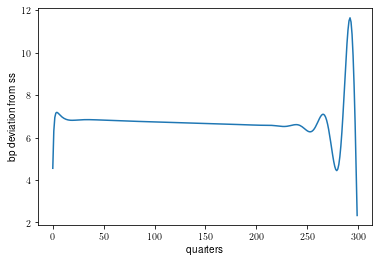

In [20]:
rhos = np.array([0.4]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['P']['rstar'] @ drstar

plt.plot(10000 * dpi[:500])
#plt.title(r'Inflation responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

<a id="5-determinacy"></a>

## 4. Local determinacy

In [21]:
# smallest singular values
_, s, _ = np.linalg.svd(H_U)
print(f'Smallest singular values: {s[-3]:.4f}, {s[-2]:.4f}, {s[-1]:.4f}')

# winding number test
# first, use get_H_U with asymptotic=True to get array A representing asymptotic H_U
A = jac.get_H_U(block_list, unknowns, targets, T, ss, asymptotic=True, save=True, use_saved=True)

# then apply winding number criterion
wn = det.winding_criterion(A)
print(f'Winding number: {wn}')

Smallest singular values: 0.0353, 0.0213, 0.0073
Winding number: 0
